Import packages

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers, Sequential

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy import stats

import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
pd.set_option("display.max_rows", None,
             "display.max_columns", None)

In [2]:
def drop_infs(ds):
    ds.replace([np.inf, -np.inf], np.nan, inplace=True)
    ds.dropna(how='any', inplace=True)
    return ds

Get dataset

In [3]:
dataset=pd.read_csv("/Users/ecemdenizbabaoglan/Desktop/TOBBETU/yap470/test_dataset_hepsi.csv")
dataset.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,3000000.0,5.000000e+05,4.0,0.0,4,4,4,4.0,0.0,4,4,0,0.0,0.0,0,0,0,0,0,0,40,0,5.000000e+05,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,12000000.0,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,12000000.0,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,12000000.0,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4000000.0,6.666667e+05,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,6.666667e+05,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,245,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
dataset=drop_infs(dataset)

labels = dataset[' Label'].copy()

le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = pd.DataFrame(labels_encoded, columns=[' Label'])
labels_encoded = labels_encoded[' Label'].copy()

In [5]:
labels.unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [6]:
labels.value_counts()

BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64

In [7]:
labels_encoded.unique()

array([ 0,  2, 10,  1,  9, 12, 14, 13,  7, 11,  6,  5,  4,  3,  8])

In [8]:
dataset.loc[dataset[' Label'] == 'BENIGN', ' Label'] = 0 #Saldırılar için 1 normaller için 0 değeri verme
dataset.loc[dataset[' Label'] != 0, ' Label'] = 1

In [9]:
#Dataseti x ve y olarak ayırma
y=dataset[' Label']
x=dataset.drop(' Label', axis=1)
scaler=preprocessing.MinMaxScaler()
x_scaled=scaler.fit_transform(x)

In [10]:
#Dataseti normal ve anormal olarak ayırma
x_normal = x_scaled[y == 0]
x_anomaly = x_scaled[y == 1]
anomaly_labels = labels_encoded[labels_encoded!=0]

Set autoencoder & data

In [11]:
x_normal_train = np.asarray(x_normal).astype(np.float32)

x_normal_train = tf.cast(x_normal_train, tf.float32)

In [12]:
from tensorflow.keras.optimizers import Adam
autoencoder = Sequential()
autoencoder.add(Dense(32,  activation='relu', input_shape=(78,)))
autoencoder.add(Dense(16,  activation='relu'))
autoencoder.add(Dense(8,    activation='linear', name="Compressed"))
autoencoder.add(Dense(16,  activation='relu'))
autoencoder.add(Dense(32,  activation='relu'))
autoencoder.add(Dense(78,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

In [13]:
history = autoencoder.fit(x_normal_train, 
                          x_normal_train, 
                          batch_size=64,     
                          epochs=10, 
                          verbose=1, 
                          validation_split = 0.20)

2022-12-18 23:39:29.048044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-18 23:39:29.056122: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


Epoch 1/10
28392/28392 [==============================] - 19s 655us/step - loss: 0.0043 - val_loss: 3.1342e-04
Epoch 2/10
28392/28392 [==============================] - 14s 497us/step - loss: 3.1243e-04 - val_loss: 3.1767e-04
Epoch 3/10
28392/28392 [==============================] - 14s 489us/step - loss: 2.8167e-04 - val_loss: 3.0497e-04
Epoch 4/10
28392/28392 [==============================] - 14s 497us/step - loss: 2.6638e-04 - val_loss: 3.2513e-04
Epoch 5/10
28392/28392 [==============================] - 14s 492us/step - loss: 2.6314e-04 - val_loss: 3.8144e-04
Epoch 6/10
28392/28392 [==============================] - 14s 488us/step - loss: 1.5395e-04 - val_loss: 1.1076e-04
Epoch 7/10
28392/28392 [==============================] - 14s 488us/step - loss: 4.5858e-05 - val_loss: 1.2296e-04
Epoch 8/10
28392/28392 [==============================] - 14s 504us/step - loss: 4.3171e-05 - val_loss: 9.1257e-05
Epoch 9/10
28392/28392 [==============================] - 14s 510us/step - loss: 4.2

In [14]:
encoder = Model(autoencoder.input, autoencoder.get_layer('Compressed').output)

In [15]:
encoder.compile(loss='mean_squared_error', optimizer = 'adam')

In [16]:
encoded_normal = encoder.predict(x_normal)   #Normal verilerin feature değerleri
encoded_anomaly = encoder.predict(x_anomaly) #Saldırı verilerinin feature değerleri

In [17]:
encoded_x = np.append(encoded_normal, encoded_anomaly, axis = 0) #Normal ve saldırı feature değerleri birleştirme
normal_y = np.zeros(encoded_normal.shape[0])     #Normal verilerin label'ları
anomaly_y = np.ones(encoded_anomaly.shape[0])    #Saldırı verilerinin label'ları
encoded_y = np.append(normal_y, anomaly_y)       #Label birleştirme 0-1
encoded_labels = np.append(normal_y, anomaly_labels)  #Label birleştirme 0-14

In [18]:
np.unique(encoded_labels, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]),
 array([2271320,    1956,  128025,   10293,  230124,    5499,    5796,
           7935,      11,      36,  158804,    5897,    1507,      21,
            652]))

In [19]:
y_xgb = np.c_[encoded_y, encoded_labels] #1. sütun: 0-1 sınıflandırma, 2. sütun: 0-14 sınıflandırma

In [20]:
y_xgb

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 3.],
       [1., 3.],
       [1., 3.]])

In [21]:
x_train, x_test, y_train, y_test = train_test_split(encoded_x, y_xgb, 
                                                    test_size=0.20, 
                                                    random_state=12345,
                                                    stratify=y_xgb)

In [22]:
y_train_labels = y_train[:,1]  # Train verisinin y labelları
y_test_labels = y_test[:,1]    # Test verisinin y labelları

In [23]:
np.unique(y_train_labels, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]),
 array([1817055,    1565,  102420,    8234,  184099,    4399,    4637,
           6348,       9,      29,  127043,    4717,    1206,      17,
            522]))

In [24]:
c = le.inverse_transform(y_test_labels.astype(int))
np.unique(c, return_counts=True)

(array(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
        'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed',
        'Infiltration', 'PortScan', 'SSH-Patator',
        'Web Attack � Brute Force', 'Web Attack � Sql Injection',
        'Web Attack � XSS'], dtype=object),
 array([454265,    391,  25605,   2059,  46025,   1100,   1159,   1587,
             2,      7,  31761,   1180,    301,      4,    130]))

XGBoost

In [25]:
!pip install xgboost

In [26]:
from sklearn.linear_model import RidgeCV, ElasticNet, LassoCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix 

/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [27]:
model_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=1, learning_rate=0.2, verbosity=1)

cv = RepeatedStratifiedKFold(n_splits=5, random_state=12345)
n_scores = cross_val_score(model_xgb, x_train, y_train[:,0], scoring='accuracy', cv=cv, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:42:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:42:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:42:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:42:56] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:43:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:43:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:43:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:43:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:43:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:02] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:44] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:45:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:45:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:45:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:45:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:45:49] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:47] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:47:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:47:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:47:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:47:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:47:53] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:38] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:50] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:02] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:52] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.915 (0.002)


In [28]:
model_xgb.fit(x_train, y_train[:,0])
xgb_preds = model_xgb.predict(x_test)

/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
model_xgb.score(x_test, y_test[:,0])

0.9137976151746184

First training

In [30]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test[:,0], xgb_preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test[:,0], xgb_preds))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    454265
         1.0       0.90      0.64      0.74    111311

    accuracy                           0.91    565576
   macro avg       0.91      0.81      0.85    565576
weighted avg       0.91      0.91      0.91    565576


Accuracy Score:  0.9137976151746184


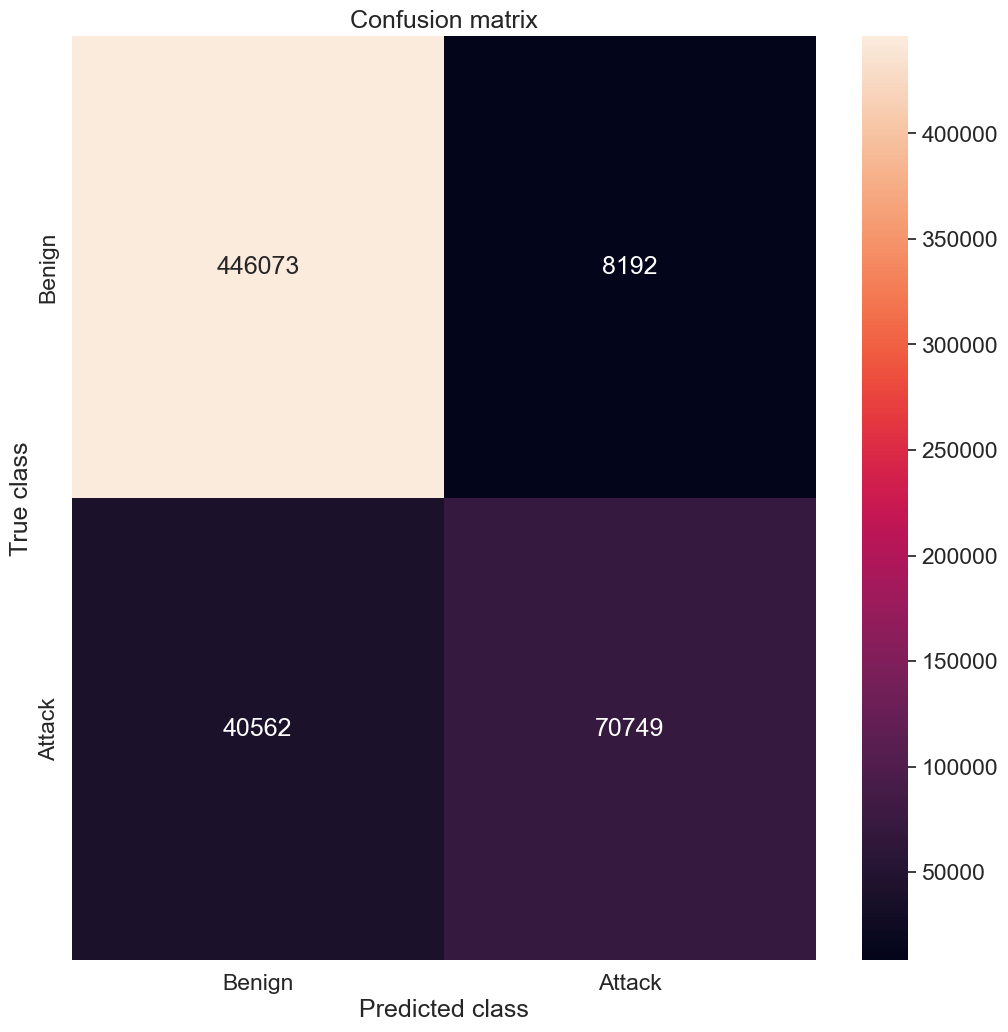

In [31]:
LABELS = ['Benign', 'Attack'] 
conf_matrix = confusion_matrix(y_test[:,0], xgb_preds) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class')
plt.xlabel('Predicted class') 
plt.show()

In [32]:
xgb_preds.shape

(565576,)

In [33]:
y_test_labels.shape

(565576,)

Predict Attack Types

In [34]:
anomaly_pred_x = []
anomaly_pred_labels = []
predi = [] # doğru mu yanlış mı bildik kontrol
for i in range(len(xgb_preds)):
    if (xgb_preds[i]==y_test[i,0]) and (xgb_preds[i]==1):
        anomaly_pred_x.append(x_test[i,:])
        anomaly_pred_labels.append(y_test_labels[i])
    if xgb_preds[i]==y_test[i,0]:
        predi.append(1)
    else:
        predi.append(0)
y_test = np.c_[y_test, predi] #1. sütun: 0-1 sınıflandırma, 2. sütun: 0-14 sınıflandırma, 3. sütun: predict doğruluğu
pred_anomaly_x = np.array(anomaly_pred_x) #Test verisinde doğru bilinen anomalilerin x'leri
pred_anomaly_y = np.array(anomaly_pred_labels)  #Test verisinde doğru bilinen anomalilerin y'leri

In [35]:
y_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 4., 1.]])

In [36]:
benign_toplam=0
bot_toplam=0
ddos_toplam=0
dos_goldenEye_toplam=0
dos_hulk_toplam=0
dos_slowhttptest_toplam=0
dos_slowloris_toplam=0
ftp_patator_toplam=0
heartbleed_toplam=0
infiltration_toplam=0
portScan_toplam=0
ssh_patator_toplam=0
brute_force_toplam=0
sql_injection_toplam=0
xss_toplam=0

for i in range(len(y_test)):
    statement=y_test[i,1]
    if statement==0:
        benign_toplam+=1
    elif statement==1:
        bot_toplam+=1
    elif statement==2:
        ddos_toplam+=1
    elif statement==3:
        dos_goldenEye_toplam+=1
    elif statement==4:
        dos_hulk_toplam+=1
    elif statement==5:
        dos_slowhttptest_toplam+=1
    elif statement==6:
        dos_slowloris_toplam+=1
    elif statement==7:
        ftp_patator_toplam+=1
    elif statement==8:
        heartbleed_toplam+=1
    elif statement==9:
        infiltration_toplam+=1
    elif statement==10:
        portScan_toplam+=1
    elif statement==11:
        ssh_patator_toplam+=1
    elif statement==12:
        brute_force_toplam+=1
    elif statement==13:
        sql_injection_toplam+=1
    elif statement==14:
        xss_toplam+=1

In [37]:
# Bu labela sahip kaç tane verinin anomali olup olmadığı doğru bilindiği sayısı tutuluyor
benign=0
bot=0
ddos=0
dos_goldenEye=0
dos_hulk=0
dos_slowhttptest=0
dos_slowloris=0
ftp_patator=0
heartbleed=0
infiltration=0
portScan=0
ssh_patator=0
brute_force=0
sql_injection=0
xss=0

for i in range(len(y_test)):
    if y_test[i,2]==1:
        statement=y_test[i,1]
        if statement==0:
            benign+=1
        elif statement==1:
            bot+=1
        elif statement==2:
            ddos+=1
        elif statement==3:
            dos_goldenEye+=1
        elif statement==4:
            dos_hulk+=1
        elif statement==5:
            dos_slowhttptest+=1
        elif statement==6:
            dos_slowloris+=1
        elif statement==7:
            ftp_patator+=1
        elif statement==8:
            heartbleed+=1
        elif statement==9:
            infiltration+=1
        elif statement==10:
            portScan+=1
        elif statement==11:
            ssh_patator+=1
        elif statement==12:
            brute_force+=1
        elif statement==13:
            sql_injection+=1
        elif statement==14:
            xss+=1

In [38]:
print("Benign : ",(benign/benign_toplam)*100)
print("Bot : ",(bot/bot_toplam)*100)
print("DDos : ",(ddos/ddos_toplam)*100)
print("Dos GoldenEye : ",(dos_goldenEye/dos_goldenEye_toplam)*100)
print("Dos Hulk : ",(dos_hulk/dos_hulk_toplam)*100)
print("Dos Slow HTTP Test : ",(dos_slowhttptest/dos_slowhttptest_toplam)*100)
print("Dos SlowLoris : ",(dos_slowloris/dos_slowloris_toplam)*100)
print("FTP Patator : ",(ftp_patator/ftp_patator_toplam)*100)
print("Heartbleed : ",(heartbleed/heartbleed_toplam)*100)
print("Infiltration : ",(infiltration/infiltration_toplam)*100)
print("PortScan : ",(portScan/portScan_toplam)*100)
print("SSH Patator : ",(ssh_patator/ssh_patator_toplam)*100)
print("Brute Force : ",(brute_force/brute_force_toplam)*100)
print("SQL Injection : ",(sql_injection/sql_injection_toplam)*100)
print("XSS : ",(xss/xss_toplam)*100)


Benign :  98.19664733140347
Bot :  1.0230179028132993
DDos :  50.42374536223394
Dos GoldenEye :  53.22972316658572
Dos Hulk :  80.2607278652906
Dos Slow HTTP Test :  0.0
Dos SlowLoris :  18.3779119930975
FTP Patator :  0.0
Heartbleed :  0.0
Infiltration :  14.285714285714285
PortScan :  61.6542300305406
SSH Patator :  0.0847457627118644
Brute Force :  0.33222591362126247
SQL Injection :  0.0
XSS :  0.0


In [39]:
pred_anomaly_y = pred_anomaly_y.astype(int)

In [40]:
np.unique(pred_anomaly_y, return_counts=True)

(array([ 1,  2,  3,  4,  6,  9, 10, 11, 12]),
 array([    4, 12911,  1096, 36940,   213,     1, 19582,     1,     1]))

In [41]:
a = le.inverse_transform(pred_anomaly_y)
np.unique(a, return_counts=True)

(array(['Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS slowloris',
        'Infiltration', 'PortScan', 'SSH-Patator',
        'Web Attack � Brute Force'], dtype=object),
 array([    4, 12911,  1096, 36940,   213,     1, 19582,     1,     1]))

In [42]:
le2 = preprocessing.LabelEncoder() #Saldırılar 0'dan başlasın diye tekrar label encoder
pred_anomaly_y = le2.fit_transform(a)

In [43]:
np.unique(pred_anomaly_y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([    4, 12911,  1096, 36940,   213,     1, 19582,     1,     1]))

In [44]:
z = le2.inverse_transform(pred_anomaly_y)
np.unique(z, return_counts=True)

(array(['Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS slowloris',
        'Infiltration', 'PortScan', 'SSH-Patator',
        'Web Attack � Brute Force'], dtype=object),
 array([    4, 12911,  1096, 36940,   213,     1, 19582,     1,     1]))

In [45]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(pred_anomaly_x, pred_anomaly_y, 
                                                    test_size=0.20, 
                                                    random_state=12345)

In [46]:
attack_predictor = xgb.XGBClassifier(n_estimators=100, max_depth=1, learning_rate=0.2, verbosity=1)

cv = RepeatedStratifiedKFold(n_splits=5, random_state=12345)
n_scores = cross_val_score(attack_predictor, x_train2, y_train2, scoring='accuracy', cv=cv, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

[23:52:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_en

[23:52:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:37] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:40] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:44] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:46] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:48] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:50] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:52] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:57] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:12] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:37] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:44] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:46] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:48] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:53] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:56] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.975 (0.002)


In [47]:
attack_predictor.fit(x_train2, y_train2)
attack_preds = attack_predictor.predict(x_test2)

[23:54:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [48]:
attack_predictor.score(x_test2, y_test2)

0.9731448763250884

In [49]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test2, attack_preds))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test2, attack_preds))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.96      0.91      0.93      2655
           2       0.97      0.91      0.94       204
           3       0.96      0.99      0.97      7368
           4       1.00      1.00      1.00        43
           6       1.00      1.00      1.00      3878
           8       0.00      0.00      0.00         1

    accuracy                           0.97     14150
   macro avg       0.84      0.83      0.84     14150
weighted avg       0.97      0.97      0.97     14150


Accuracy Score:  0.9731448763250884


/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ecemdenizbabaoglan/opt/anaconda3/envs/pytf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

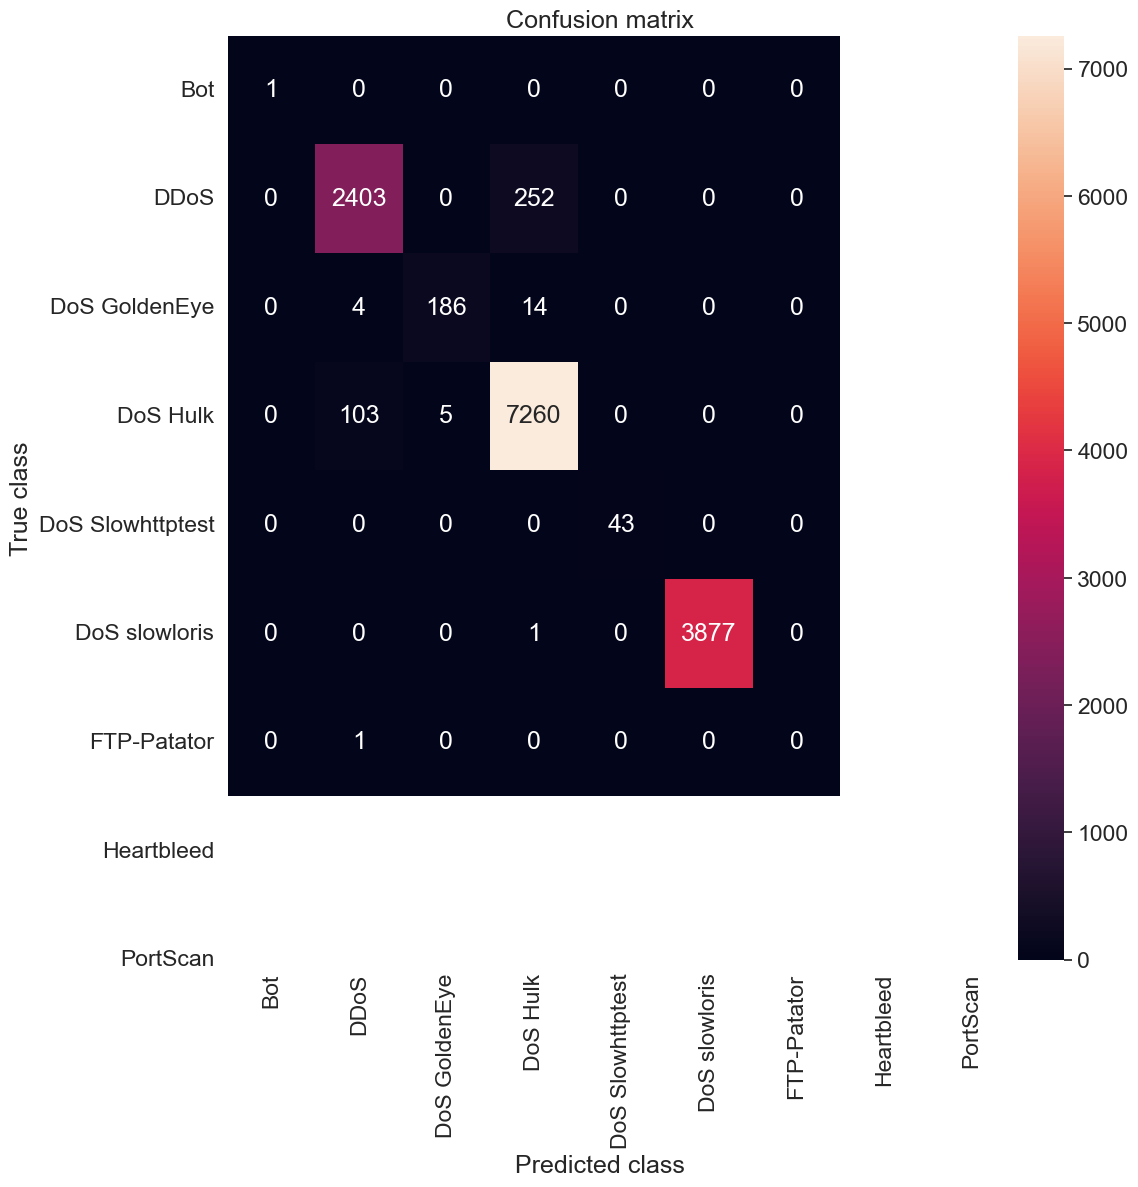

In [50]:
LABELS = ['Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest',
        'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'PortScan']
conf_matrix = confusion_matrix(y_test2, attack_preds) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class')
plt.xlabel('Predicted class') 
plt.show()

Extract the models

In [51]:
import pickle

In [52]:
pickle.dump(scaler,open("scaler.pkl","wb"))
pickle.dump(encoder, open("encoder.pkl", "wb"))
pickle.dump(model_xgb, open("first_predict.pkl", "wb"))
pickle.dump(attack_predictor, open("second_predict.pkl", "wb"))

TypeError: cannot pickle 'weakref' object